In [81]:
prefix = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/"

SELECTION = "D"

if SELECTION == "A":
    network_fns = [
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt___2050.nc",
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp_2050.nc",
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+H2_2050.nc",
    ]
    scenario_names = [
        "no imports allowed",
        "all imports allowed",
        "only hydrogen imports",
    ]
elif SELECTION == "B":
    network_fns = [
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__allwasteheat_2050.nc",
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__norelocation_2050.nc",
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+AC_2050.nc",
    ]
    scenario_names = [
        "use 100% of PtX waste heat, no imports",
        "no steel/ammonia industry relocation, no imports",
        "only electricity imports",
    ]
elif SELECTION == "C":
    network_fns = [
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+H20.8_2050.nc",
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+AC+H2+CH40.9+NH3+FT0.9+MeOH0.9+HBI+St_2050.nc",
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+AC+H2+CH40.8+NH3+FT0.8+MeOH0.8+HBI+St_2050.nc",
    ]
    scenario_names = [
        "only hydrogen imports, 20% cheaper",
        "10% cheaper C-fuel imports",
        "20% cheaper C-fuel imports",
    ]
elif SELECTION == "D":
    network_fns = [
        prefix + "results/20240826-z1/postnetworks/base_s_115_lvopt__noPtXflex_2050.nc",
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__noH2network-imp+AC+CH4+NH3+FT+MeOH+HBI+St_2050.nc",
        prefix
        + "results/20240826-z1/postnetworks/base_s_115_lvopt__imp+CH4+NH3+FT+MeOH+HBI+St_2050.nc",
    ]
    scenario_names = [
        "no imports, no PtX flexibility",
        "imports without hydrogen, no hydrogen network",
        "only hydrogen derivative imports",
    ]

regions_fn = prefix + "resources/20240826-z1/regions_onshore_base_s_115.geojson"
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
import_fn = "../pypsa-eur/data/imports/results.parquet"
config_fn = "../pypsa-eur/config/config.default.yaml"


RUN = "20240826-z1"
OUTPUT = f"./{RUN}/"

In [82]:
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


sys.path.append("../pypsa-eur/scripts")

from plot_power_network import assign_location as old_assign_location
from pypsa.plot import add_legend_circles, add_legend_lines


plt.style.use(["bmh", matplotlibrc_fn])

In [83]:
# from https://github.com/FabianHofmann/co2-network/blob/master/workflow/scripts/common.py
def assign_location(n):
    for c in n.one_port_components | n.branch_components:
        df = n.df(c)

        if "location" not in df:
            df["location"] = np.nan

        bus_col = df.columns[df.columns.str.startswith("bus")][0]
        df["location"] = df[bus_col].map(n.buses.location)


def assign_interconnection(n):
    for c in n.branch_components:
        df = n.df(c)
        if df.empty:
            continue

        location0 = df.bus0.map(n.buses.location)
        location1 = df.bus1.map(n.buses.location)
        locations = pd.concat([location0, location1], axis=1)
        df["location0"] = location0
        df["location1"] = location1

        connections = locations.apply(lambda ds: " - ".join(sorted(ds)), axis=1)
        connections = connections.where(location0 != location1)
        df["interconnection"] = connections


def fill_missing_carriers(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        new_carriers = set(c.df.carrier.unique()) - set(n.carriers.index)
        if new_carriers:
            n.madd("Carrier", list(new_carriers))


def sanitize_locations(n):
    old_assign_location(n)
    if "EU" in n.buses.index:
        n.remove("Bus", "EU")
    n.add("Bus", "EU", x=-6.5, y=45)
    n.buses.loc[n.buses.index.str.startswith("EU"), "location"] = "EU"
    iso2_buses = n.buses.index.str.len() == 2
    n.buses.loc[iso2_buses, "location"] = n.buses.index[iso2_buses]
    copperplated = ["co2 atmosphere", "process emissions", "solid biomass for industry"]
    n.buses.loc[copperplated, "location"] = "EU"
    assign_location(n)
    assign_interconnection(n)
    fill_missing_carriers(n)
    n.buses["x"] = n.buses.location.map(n.buses.x)
    n.buses["y"] = n.buses.location.map(n.buses.y)
    if "KZ" in n.buses.index:
        n.buses.loc["KZ", "x"] = 52
        n.buses.loc["KZ", "y"] = 49
    if "CN-West" in n.buses.index:
        n.buses.loc["CN-West", "x"] = 79
        n.buses.loc["CN-West", "y"] = 38
    for ct in n.buses.index.intersection({"MA", "DZ", "TN", "LY", "EG", "SA"}):
        n.buses.loc[ct, "y"] += 2
    for ct in n.buses.index.intersection({"UA", "TR"}):
        n.buses.loc[ct, "x"] -= 7
    idx = n.buses.query("carrier == 'import pipeline-h2'").index
    n.buses.loc[idx, "location"] = idx.str.split(" ").str[:2].str.join(" ")


def get_transmission_links(n, with_eu=False):
    # only choose transmission links
    if with_eu:
        return n.links.bus0.map(n.buses.location) != n.links.bus1.map(n.buses.location)
    return (
        (n.links.bus0.map(n.buses.location) != n.links.bus1.map(n.buses.location))
        & ~n.links.bus0.map(n.buses.location).str.contains("EU")
        & ~n.links.bus1.map(n.buses.location).str.contains("EU")
    )

In [84]:
with open(config_fn, "r") as f:
    config = yaml.safe_load(f)
tech_colors = config["plotting"]["tech_colors"]
nice_names = config["plotting"]["nice_names"]

In [85]:
df = pd.read_parquet(import_fn).reset_index()
ic = df.query(
    "subcategory == 'Cost per MWh delivered' and esc == 'pipeline-h2'"
).rename(columns={"value": "marginal_cost"})

In [86]:
ns = [pypsa.Network(fn) for fn in network_fns]

INFO:pypsa.io:Imported network base_s_115_lvopt__noPtXflex_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_115_lvopt__noH2network-imp+AC+CH4+NH3+FT+MeOH+HBI+St_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_115_lvopt__imp+CH4+NH3+FT+MeOH+HBI+St_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [87]:
n = ns[0].copy()

In [88]:
for n in ns:
    sanitize_locations(n)

In [89]:
crs = ccrs.EqualEarth()

In [90]:
regions = gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)

In [91]:
def get_dispatch(n):
    is_transport = get_transmission_links(n)
    transport_carriers = [
        *n.links.carrier[is_transport].unique(),
        *n.lines.carrier.unique(),
    ]

    balance = n.statistics.energy_balance(
        nice_names=False,
        groupby=n.statistics.groupers.get_bus_and_carrier_and_bus_carrier,
    )
    balance = balance.rename(n.buses.location, level="bus")
    dispatch = balance.drop(transport_carriers, level="carrier")
    dispatch = dispatch.drop("", level="bus", errors="ignore")
    dispatch = dispatch.drop("battery discharger", level="carrier", errors="ignore")

    return dispatch

In [92]:
def get_copperplated_imports(n):

    eu_sizes = {}

    carriers = [
        "import shipping-lch4",
        "import shipping-ftfuel",
        "import shipping-meoh",
        "import shipping-lnh3",
        "import shipping-steel",
        "import shipping-hbi",
    ]
    for carrier in carriers:
        if carrier in n.links.carrier.unique():
            carrier_i = n.links[n.links.carrier == carrier].index
            energy = weights @ n.links_t.p0.loc[:, carrier_i]
            eu_sizes[("EU", carrier.split(" ")[-1])] = energy.sum()

    eu_sizes = pd.Series(eu_sizes, dtype=float)
    if not eu_sizes.empty:
        eu_sizes.index.names = ["bus", "carrier"]

    return eu_sizes

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/fneum/miniconda3/envs/pypsa-eur-240812/lib/python

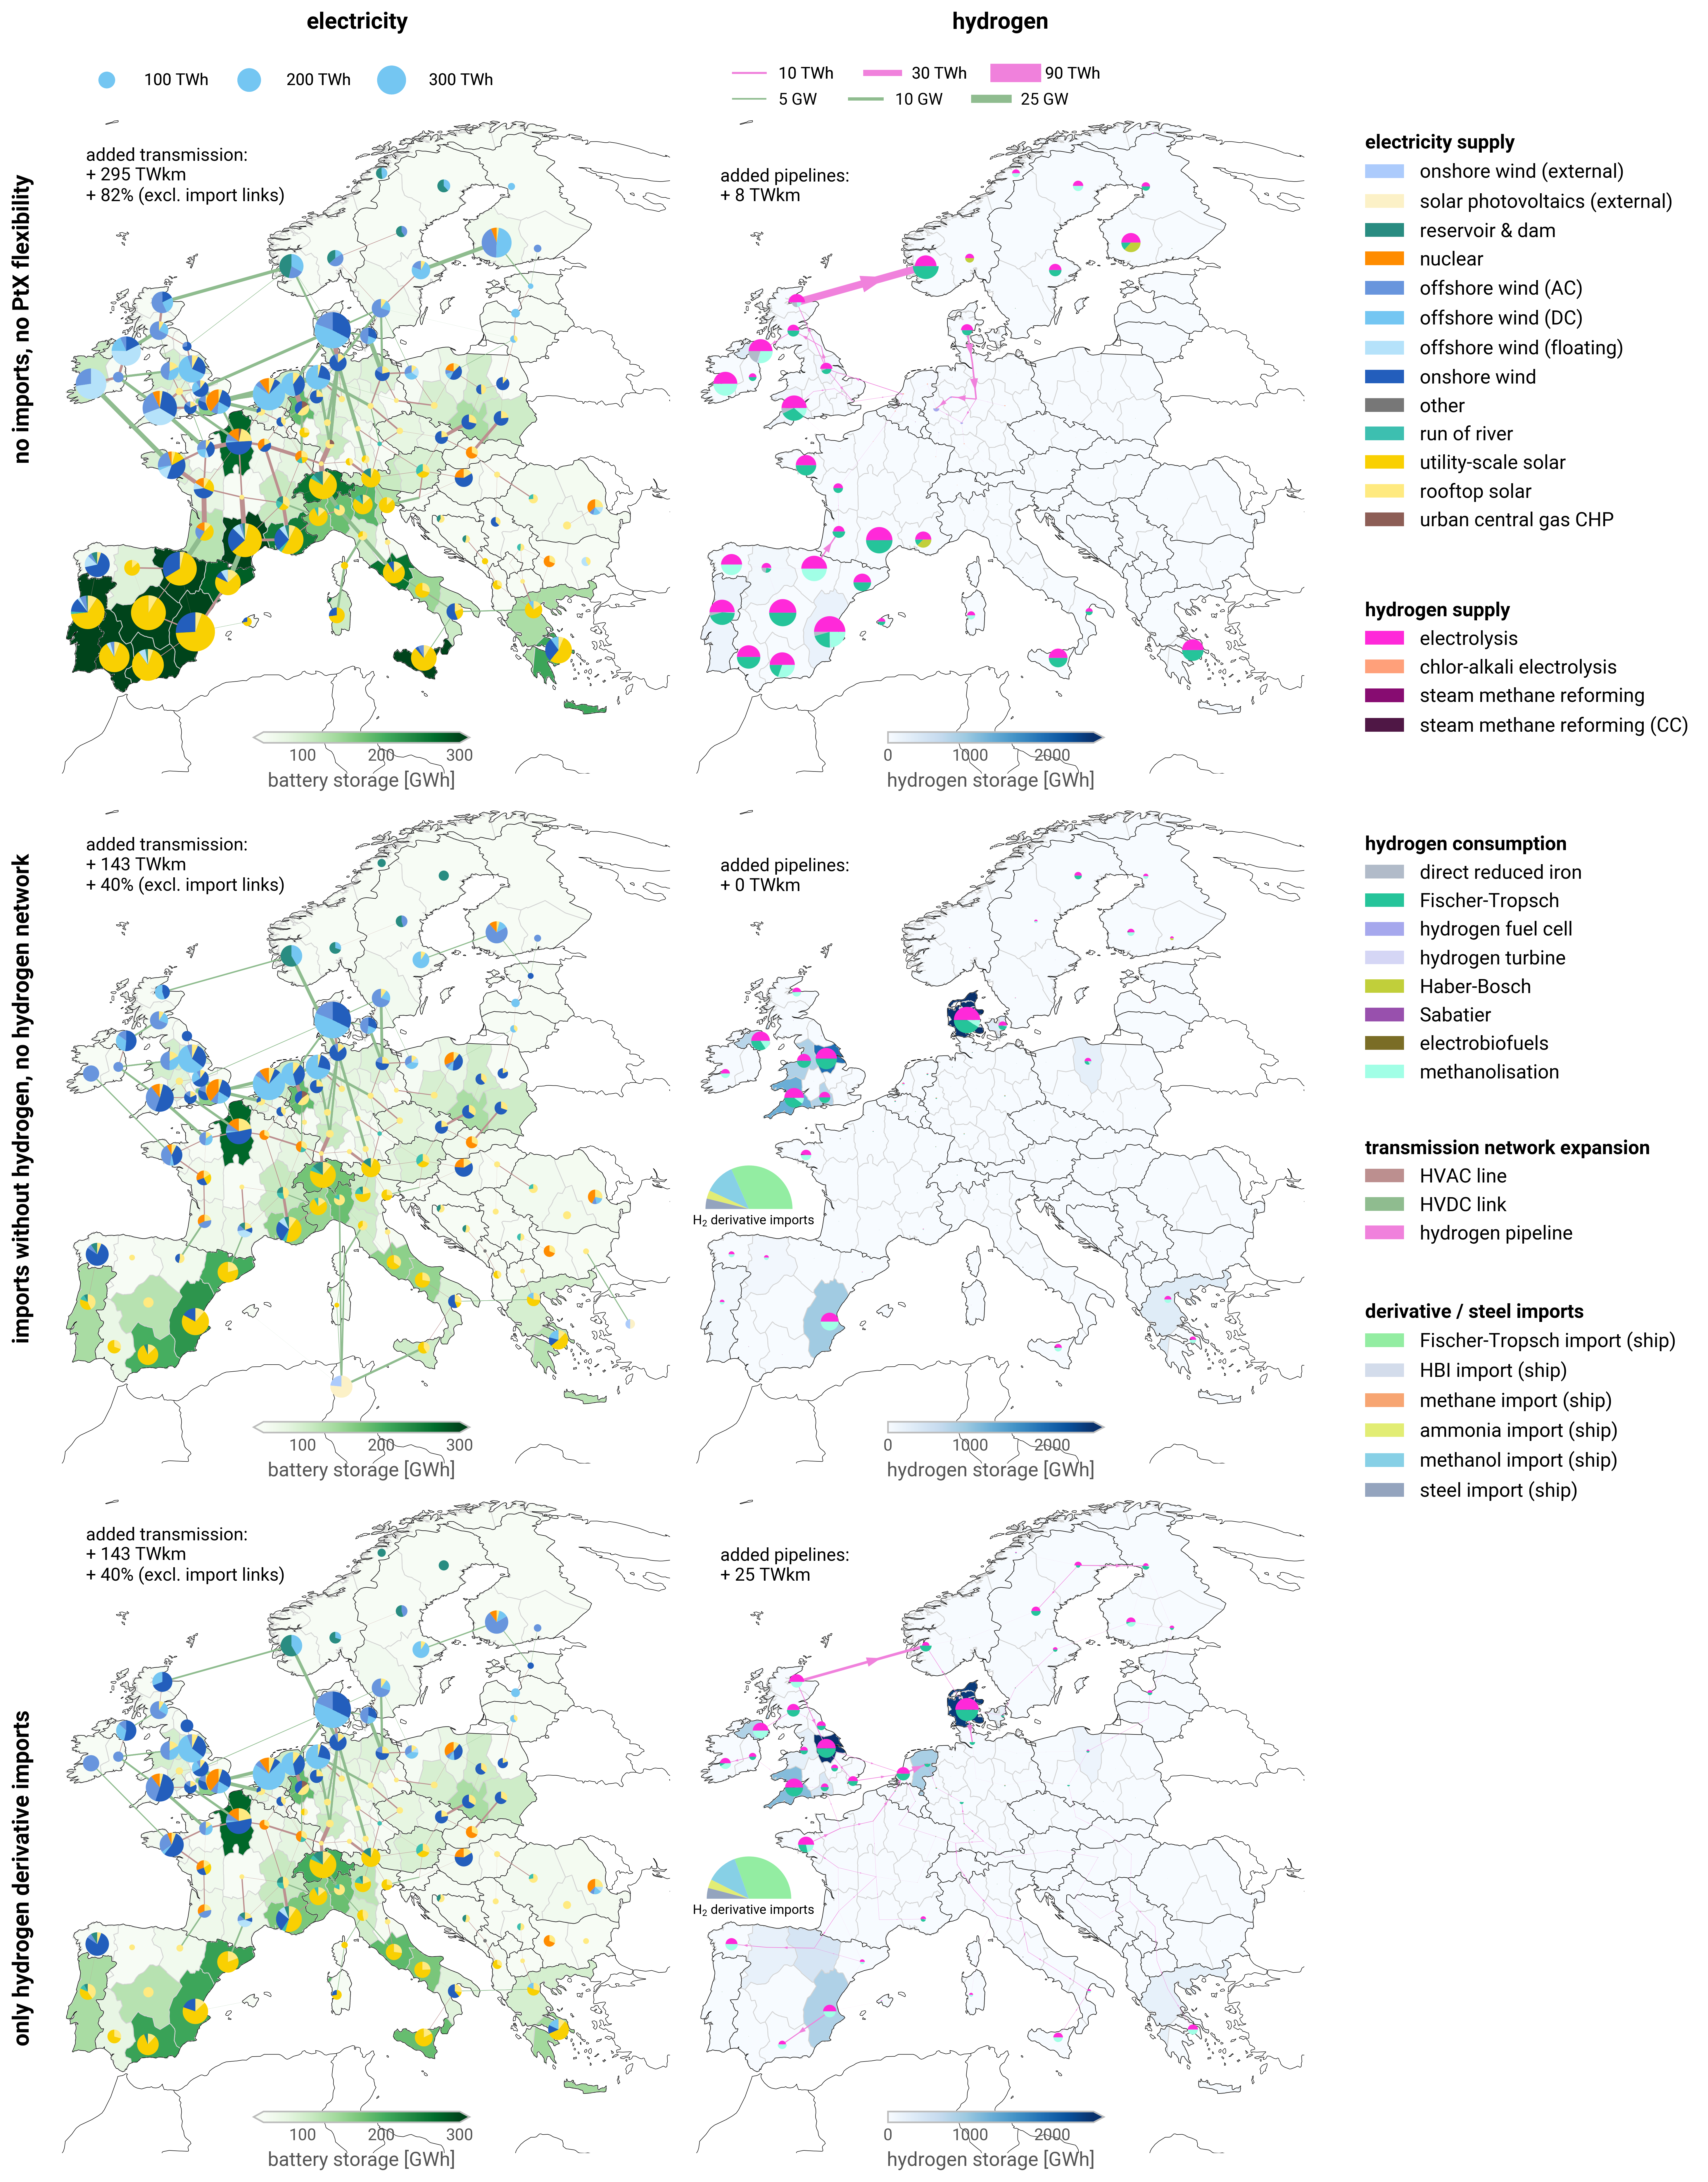

In [93]:
from matplotlib.transforms import Bbox

BOUNDARIES = [-10, 30, 32, 71.5]

fig, axs = plt.subplots(
    3,
    2,
    subplot_kw={"projection": crs},
    figsize=(11, 20),
)

plt.subplots_adjust(wspace=0, hspace=0, right=0.2, left=0.15)

elec_labels = []
h2_supply_labels = []
h2_demand_labels = []
eu_import_labels = []

fig.text(
    0.25,
    0.96,
    "electricity",
    va="center",
    ha="center",
    size=14,
    fontweight="bold",
)

fig.text(
    0.75,
    0.96,
    "hydrogen",
    va="center",
    ha="center",
    size=14,
    fontweight="bold",
)

for i, n in enumerate(ns):

    n = n.copy()

    regions["battery"] = (
        n.stores.filter(like="battery", axis=0)
        .groupby("location")
        .e_nom_opt.sum()
        .div(1e3)
    )
    regions["hydrogen"] = (
        n.stores.filter(like="H2 Store", axis=0)
        .groupby("location")
        .e_nom_opt.sum()
        .div(1e3)
    )

    dispatch = get_dispatch(n)

    # power network

    bus_scale = 5e-9
    branch_scale_el = 2e-4

    elec_bus_carriers = dispatch.index.get_level_values("bus_carrier").str.contains(
        "AC|low voltage"
    )
    bus_sizes = dispatch.loc[elec_bus_carriers].groupby(["bus", "carrier"]).sum()
    mask = bus_sizes < 5e6
    bus_sizes.index = pd.MultiIndex.from_tuples(
        [(idx[0], "other" if mask.loc[idx] else idx[1]) for idx in bus_sizes.index]
    )
    bus_sizes = bus_sizes.groupby(level=[0, 1]).sum()

    carriers = ["AC", "DC", "import hvdc-to-elec"]
    links = n.links.query("carrier in @carriers")
    df = links.p_nom_opt - links.p_nom_min
    link_widths = df[df > 100]
    lines = n.lines.query("carrier in @carriers")
    df = lines.s_nom_opt - lines.s_nom_min
    line_widths = df[df > 100]

    elec_labels += bus_sizes.index.get_level_values(1).unique().tolist()

    n.plot(
        ax=axs[i, 0],
        bus_sizes=bus_sizes * bus_scale,  # 1
        bus_colors=tech_colors,
        line_widths=line_widths.abs().reindex(n.lines.index, fill_value=0)
        * branch_scale_el,
        link_widths=link_widths.abs().reindex(n.links.index, fill_value=0)
        * branch_scale_el,
        boundaries=BOUNDARIES,
        margin=0.15,
    )

    regions.plot(
        ax=axs[i, 0],
        column="battery",
        cmap="Greens",
        linewidths=0.5,
        edgecolor="lightgray",
        legend=True,
        vmin=50,
        vmax=300,
        legend_kwds={
            "label": r"battery storage [GWh]",
            "shrink": 0.35,
            "pad": -0.045,
            "orientation": "horizontal",
            "extend": "both",
        },
    )

    existing_twkm = (
        n.links.query("carrier == 'DC'").eval("p_nom * length").sum()
        + n.lines.eval("s_nom * length").sum()
    )
    optimised_twkm = (
        n.links.query("carrier == 'DC'").eval("p_nom_opt * length").sum()
        + n.lines.eval("s_nom_opt * length").sum()
    )
    increase_twkm_rel = round((optimised_twkm - existing_twkm) / existing_twkm * 100)
    increase_twkm_abs = round((optimised_twkm - existing_twkm) / 1e6)

    axs[i, 0].text(
        -70e4,
        730e4,
        f"added transmission:\n+ {increase_twkm_abs} TWkm\n+ {increase_twkm_rel}% (excl. import links)",
        fontsize=11,
        transform=crs,
    )

    fig.text(
        -0.01,
        1 - (2 * i + 1) / 6,
        scenario_names[i],
        va="center",
        ha="center",
        rotation="vertical",
        size=14,
        fontweight="bold",
    )

    # hydrogen network

    bus_scale = 3.5e-9
    branch_scale_h2 = 1.25e-7
    flow_scale = 1.5e-5

    bus_sizes = dispatch.xs("H2", level="bus_carrier").groupby(["bus", "carrier"]).sum()
    copperplated_imports = get_copperplated_imports(n)
    bus_sizes = pd.concat([bus_sizes, copperplated_imports])
    bus_sizes = bus_sizes[bus_sizes.abs() > 10]

    carriers = ["H2 pipeline", "H2 pipeline retrofitted"]
    optimised_twkm = (
        n.links.query("carrier in @carriers").eval("p_nom_opt * length").sum()
    )
    increase_twkm_abs = round(optimised_twkm / 1e6)

    h2_supply_labels += (
        bus_sizes[bus_sizes > 0]
        .drop(copperplated_imports.index, errors="ignore")
        .index.get_level_values(1)
        .unique()
        .tolist()
    )
    h2_demand_labels += (
        bus_sizes[bus_sizes < 0].index.get_level_values(1).unique().tolist()
    )
    if not copperplated_imports.empty:
        eu_import_labels += (
            copperplated_imports.index.get_level_values(1).unique().tolist()
        )

    h2_pipelines = n.links.query("carrier in @carriers").copy()
    weights = n.snapshot_weightings.generators
    h2_pipelines["flow"] = weights @ n.links_t.p0.loc[:, h2_pipelines.index]
    h2_pipelines["bus0"] = h2_pipelines.bus0.map(n.buses.location)
    h2_pipelines["bus1"] = h2_pipelines.bus1.map(n.buses.location)
    positive_order = h2_pipelines.bus0 < h2_pipelines.bus1
    h2_pipelines_p = h2_pipelines[positive_order]
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    h2_pipelines_n = h2_pipelines[~positive_order].rename(columns=swap_buses)
    h2_pipelines_n["flow"] *= -1
    h2_pipelines = pd.concat([h2_pipelines_p, h2_pipelines_n])
    flow = h2_pipelines.groupby(["bus0", "bus1"])["flow"].sum()
    flow = flow[flow.abs() > 1e5]
    bus0 = flow.index.get_level_values("bus0")
    bus1 = flow.index.get_level_values("bus1")
    flow.index = flow.index.map(lambda x: x[0] + " - " + x[1])
    n.mremove("Link", n.links.index)
    n.madd("Link", flow.index, bus0=bus0, bus1=bus1)

    abs_flow = flow.abs()

    flow_dict = {}
    flow_dict["Link"] = flow.clip(lower=-8e6, upper=8e6)
    flow = pd.concat(flow_dict)

    n.plot(
        ax=axs[i, 1],
        bus_sizes=bus_sizes * bus_scale,
        bus_colors=tech_colors,
        line_widths=0,
        link_widths=abs_flow * branch_scale_h2,
        flow=flow * flow_scale,
        link_colors=tech_colors["H2 pipeline"],
        bus_split_circles=True,
        margin=0.15,
        boundaries=BOUNDARIES,
    )

    regions.plot(
        ax=axs[i, 1],
        column="hydrogen",
        cmap="Blues",
        linewidths=0.5,
        edgecolor="lightgray",
        legend=True,
        vmin=0,
        vmax=2500,
        legend_kwds={
            "label": r"hydrogen storage [GWh]",
            "shrink": 0.35,
            "pad": -0.045,
            "orientation": "horizontal",
            "extend": "max",
        },
    )

    axs[i, 1].text(
        -70e4,
        730e4,
        f"added pipelines:\n+ {increase_twkm_abs} TWkm",
        fontsize=11,
        transform=crs,
    )

    if not copperplated_imports.empty:
        axs[i, 1].text(
            -86e4,
            538e4,
            r"H$_2$ derivative imports",
            fontsize=8,
            transform=crs,
        )

    # if i == 0:
    #    break


def create_legend(labels, title, anchor_y):
    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(1.02, anchor_y),
        frameon=False,
        # title=title,
        alignment="left",
        bbox_transform=fig.transFigure,
        fontsize=12,
        # title_fontsize=12,
    )
    unique_labels = np.unique(labels)
    colors = [tech_colors.get(l, "gray") for l in unique_labels]
    nice_labels = [nice_names.get(l, l) for l in unique_labels]
    handles = [Patch(facecolor=c) for c in colors]
    legend = fig.legend(handles, nice_labels, **legend_kw)
    legend.set_title(title, prop={"size": 12, "weight": "bold"})


transmission_labels = ["AC", "DC", "H2 pipeline"]
create_legend(elec_labels, "electricity supply", 0.92)
create_legend(h2_supply_labels, "hydrogen supply", 0.72)
create_legend(h2_demand_labels, "hydrogen consumption", 0.62)
create_legend(transmission_labels, "transmission network expansion", 0.49)
create_legend(eu_import_labels, "derivative / steel imports", 0.42)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.09),
    frameon=False,
    ncol=3,
    labelspacing=1.1,
)

add_legend_circles(
    axs[0, 0],
    [100e6 * bus_scale, 200e6 * bus_scale, 300e6 * bus_scale],
    ["100 TWh", "200 TWh", "300 TWh"],
    patch_kw=dict(facecolor=tech_colors["offwind-dc"]),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.06),
    frameon=False,
    labelspacing=0.8,
    ncol=3,
)

add_legend_lines(
    axs[0, 1],
    [5e3 * branch_scale_el, 10e3 * branch_scale_el, 25e3 * branch_scale_el],
    ["5 GW", "10 GW", "25 GW"],
    patch_kw=dict(color=tech_colors["DC"]),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.1),
    frameon=False,
    labelspacing=0.8,
    ncol=3,
)

add_legend_lines(
    axs[0, 1],
    [10e6 * branch_scale_h2, 30e6 * branch_scale_h2, 90e6 * branch_scale_h2],
    ["10 TWh", "30 TWh", "90 TWh"],
    patch_kw=dict(color=tech_colors["H2 pipeline"]),
    legend_kw=legend_kw,
)

fig.canvas.draw()

for ext in [".pdf", ".png"]:
    plt.savefig(
        OUTPUT + "infrastructure-map-2x3-" + SELECTION + ext,
        dpi=fig.dpi,
        bbox_inches=Bbox([[-0.5, 0.5], [14.5, 19.6]]),
    )